<a href="https://colab.research.google.com/github/cfont03/Anomaly-breast-cancer-detection/blob/main/preprocess/0.%20Data_Cleansing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Data upload

In [ ]:
# Mount google drive
import zipfile
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Access and unzip images
!unzip -q "/content/gdrive/MyDrive/01_Database/archive.zip"
print("DONE!")

DONE!


In [ ]:
from pathlib import Path
# Images directory
path = Path("/content/archive")

In [ ]:
# Importation of libraries, which will be needed during the data cleansing
from tensorflow import keras 
print("Keras version   : ", keras.__version__)

%tensorflow_version 2.x
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Multiply, Flatten,
     Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D)
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Model

%pylab inline
import cv2
import glob
import os
import matplotlib.pylab as plt

#from PIL import Image
import PIL.Image
from fastai.vision import *
from fastai.metrics import error_rate
from IPython.display import Image
from keras.preprocessing import image as kp_image
#from tensorflow_addons.utils.ensure_tf_install import _check_tf_version
#import tensorflow_addons as tfa

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix

import seaborn as sns

Keras version   :  2.8.0
Populating the interactive namespace from numpy and matplotlib


#1. Exploratory analysis of data

In [ ]:
# Number of files in the folder

files = folders = 0

for _, dirnames, filenames in os.walk(path):
    files += len(filenames)
    folders += len(dirnames)

print ("{:} total number of files".format(files))

329 total number of files


In [ ]:
# Label exploration in .txt file
df_info = pd.read_csv("/content/archive/Info.txt", sep = " ", header = 'infer')

# Attribute info
print("Number of attributes: " , df_info.columns.values)

# Number of files
print("Number of files: ", df_info.shape[0])

# check df
print(df_info.head())

Number of attributes:  ['REFNUM' 'BG' 'CLASS' 'SEVERITY' 'X' 'Y' 'RADIUS' 'Unnamed: 7']
Number of files:  330
   REFNUM BG CLASS SEVERITY      X      Y  RADIUS  Unnamed: 7
0  mdb001  G  CIRC        B  535.0  425.0   197.0         NaN
1  mdb002  G  CIRC        B  522.0  280.0    69.0         NaN
2  mdb003  D  NORM      NaN    NaN    NaN     NaN         NaN
3  mdb004  D  NORM      NaN    NaN    NaN     NaN         NaN
4  mdb005  F  CIRC        B  477.0  133.0    30.0         NaN


In [ ]:
# Check for NaN in each column
df_info.isnull().sum(axis = 0)

REFNUM          0
BG              0
CLASS           0
SEVERITY      207
X             211
Y             211
RADIUS        211
Unnamed: 7    330
dtype: int64

In [ ]:
# NaN in last column = number of rows ====> drop last column
df_info = df_info.iloc[:, :-1]

In [ ]:
# Check number of cases per class of abnormality
df_info.groupby(['CLASS']).size()

CLASS
ARCH     19
ASYM     15
CALC     30
CIRC     25
MISC     15
NORM    207
SPIC     19
dtype: int64

In [ ]:
# we are only interested in the images, which present an abnormality. 
  # Drop NORM Class, equivalent to NaN values in Severity, x, y and Radius attributes
df_info_ = df_info.dropna()

# check it was correctly dropped
print(df_info_.groupby(['CLASS']).size())

CLASS
ARCH    19
ASYM    15
CALC    27
CIRC    24
MISC    15
SPIC    19
dtype: int64


In [ ]:
# Only keep coordinates, radius and class
df_info_ = df_info_.drop(df_info_.columns[[1,3]], axis = 1)

print(df_info_)

# check for number of files
print('\n\nNumber of images in dataset: ' , len(df_info_))

     REFNUM CLASS      X      Y  RADIUS
0    mdb001  CIRC  535.0  425.0   197.0
1    mdb002  CIRC  522.0  280.0    69.0
4    mdb005  CIRC  477.0  133.0    30.0
5    mdb005  CIRC  500.0  168.0    26.0
10   mdb010  CIRC  525.0  425.0    33.0
..      ...   ...    ...    ...     ...
281  mdb274  MISC  127.0  505.0   123.0
297  mdb290  CIRC  337.0  353.0    45.0
319  mdb312  MISC  240.0  263.0    20.0
321  mdb314  MISC  518.0  191.0    39.0
322  mdb315  CIRC  516.0  447.0    93.0

[119 rows x 5 columns]


Number of images in dataset:  119


In [ ]:
# Check again for NaN values
print(df_info_.isnull().sum(axis = 0))

# convert radius and coordinates into numeric values
df_info_.loc[:, 'RADIUS'] = pd.to_numeric(df_info_.RADIUS, downcast='integer')
df_info_.loc[:, 'X'] = pd.to_numeric(df_info_.X, downcast='integer')
df_info_.loc[:, 'Y'] = pd.to_numeric(df_info_.Y, downcast='integer')

##### CHECKPOINT
# save file into .csv
df_info_.to_csv("/content/archive/images_info_0.csv", sep = ",")

REFNUM    0
CLASS     0
X         0
Y         0
RADIUS    0
dtype: int64


In [ ]:
# Map images names with .txt file, which contains the labels
data = []
x_coord = []
y_coord = []
size = []
names = []
radius = []
image_path = []
cat = []

with open('/content/archive/images_info_0.csv') as file:
  next(file) # skip header
  for l in file:
    i = l.split(",")[1]
    images_path = '/content/archive/all-mias/{:}.pgm'.format(i)
    img = PIL.Image.open(images_path)
    data_arr = np.array(img.getdata())
    width, height = np.array(img.size)
    data.append(data_arr)
    size.append((width, height))
    names.append(np.array(i))
    cat.append(np.array(l.split(",")[2]))
    x_coord.append(np.array(l.split(",")[3]))
    y_coord.append(np.array(l.split(",")[4]))
    radius.append(np.array((l.split(",")[5]).rstrip()))
    image_path.append(images_path)


In [ ]:
# merge data into a df
arr = np.array([names, data, size, cat, x_coord, y_coord, radius, image_path], dtype = object).T.tolist()
df = pd.DataFrame(data = arr, columns = ['name', 'features', 'size', 'cat', 'x_coord', 'y_coord', 'radius', 'image path'])

# check df
df.head()

,name,features,size,cat,x_coord,y_coord,radius,image path
0,mdb001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,535,425,197,/content/archive/all-mias/mdb001.pgm
1,mdb002,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,522,280,69,/content/archive/all-mias/mdb002.pgm
2,mdb005,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,477,133,30,/content/archive/all-mias/mdb005.pgm
3,mdb005,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,500,168,26,/content/archive/all-mias/mdb005.pgm
4,mdb010,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,525,425,33,/content/archive/all-mias/mdb010.pgm


In [ ]:
# substract y-coord from 1024 value to mirror
df['y_coord'] = 1024 - df['y_coord'].astype(str).astype(int)

In [ ]:
df.head()

,name,features,size,cat,x_coord,y_coord,radius,image path
0,mdb001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,535,599,197,/content/archive/all-mias/mdb001.pgm
1,mdb002,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,522,744,69,/content/archive/all-mias/mdb002.pgm
2,mdb005,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,477,891,30,/content/archive/all-mias/mdb005.pgm
3,mdb005,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,500,856,26,/content/archive/all-mias/mdb005.pgm
4,mdb010,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,525,599,33,/content/archive/all-mias/mdb010.pgm


In [ ]:
# check if all images have the same size
df.groupby(['size']).count()

,name,features,cat,x_coord,y_coord,radius,image path
size,,,,,,,
"(1024, 1024)",119,119,119,119,119,119,119


In [ ]:
# check for duplicated images
df[df.name.duplicated()].name

3      mdb005
46     mdb132
51     mdb144
90     mdb223
92     mdb226
93     mdb226
99     mdb239
105    mdb249
Name: name, dtype: object

In [ ]:
# check in which rows are these located and if the coord and radius are different
for i in df[df.name.duplicated()].name:
  print(df.loc[df['name'] == i].iloc[:,-4:])

  x_coord  y_coord radius                            image path
2     477      891     30  /content/archive/all-mias/mdb005.pgm
3     500      856     26  /content/archive/all-mias/mdb005.pgm
   x_coord  y_coord radius                            image path
45     252      236     52  /content/archive/all-mias/mdb132.pgm
46     335      258     18  /content/archive/all-mias/mdb132.pgm
   x_coord  y_coord radius                            image path
50     233       30     29  /content/archive/all-mias/mdb144.pgm
51     313      484     27  /content/archive/all-mias/mdb144.pgm
   x_coord  y_coord radius                            image path
89     523      542     29  /content/archive/all-mias/mdb223.pgm
90     591      495      6  /content/archive/all-mias/mdb223.pgm
   x_coord  y_coord radius                            image path
91     287      414      7  /content/archive/all-mias/mdb226.pgm
92     329      474     25  /content/archive/all-mias/mdb226.pgm
93     531      303      8  

Radius and coord differ, meaning more than one abnormality is present in the same image.

In [ ]:
# generate bounding boxes
df['xmin'] = df['x_coord'].apply(int) - df['radius'].apply(int)
df['xmax'] = df['x_coord'].apply(int) + df['radius'].apply(int)
df['ymin'] = df['y_coord'].apply(int) - df['radius'].apply(int)
df['ymax'] = df['y_coord'].apply(int) + df['radius'].apply(int)

###### CHECKPOINT
# Save to .csv
df.to_csv("/content/archive/images_info_1.csv", sep = ",")

# 2. Split between train and test

Before applying any data augmentation techniques, data needs to be split between train and test.

In [ ]:
def train_test_split(df, test = 0.3):

  '''

  This function splits data into train and test subsets.


  Params:

  dataframe:
    0: image name
    1: features
    2: size image
    3: class
    4: x centre coord of boundary box
    5: y centre coord of boundary box
    6: radius
    7: image path
    9, 10, 11, 12: coord of boundary box in xmax, xmin, ymax, ymin order
  
  test: % of test data of all dataframe
  val: % of validation data of train data


  '''

  df = df.sample(frac=1).reset_index() # randomize df
  
  train_lim = int(round(len(df) * (1 - test), 0))

  train = df.iloc[0:train_lim]
  test = df.iloc[train_lim + 1:-1]

  train = train.iloc[:,1:]
  test = test.iloc[:,1:]

  return train, test

In [ ]:
train, test = train_test_split(df) # apply to our data set

In [ ]:
# check results
print('Train dataset: \nNumber of images: ', len(train), '\n', train.head(2))
print('\nTest dataset: \nNumber of images: ', len(test), '\n', test.head(2))

Train dataset: 
Number of images:  83 
      name                                           features          size  \
0  mdb226  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  (1024, 1024)   
1  mdb163  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  (1024, 1024)   

    cat x_coord  y_coord radius                            image path  xmin  \
0  CALC     287      414      7  /content/archive/all-mias/mdb226.pgm   280   
1  ARCH     391      659     50  /content/archive/all-mias/mdb163.pgm   341   

   xmax  ymin  ymax  
0   294   407   421  
1   441   609   709  

Test dataset: 
Number of images:  34 
       name                                           features          size  \
84  mdb134  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 161, 213,...  (1024, 1024)   
85  mdb312  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  (1024, 1024)   

     cat x_coord  y_coord radius                            image path  xmin  \
84  MISC     469      296     49  /content/archive/all-mias/mdb

In [ ]:
#### CHECKPOINT
# save files
train.to_csv("/content/archive/train.csv", sep = ",")
test.to_csv("/content/archive/test.csv", sep = ",")

# 3. Image preprocessing

Image:  mdb315.pgm


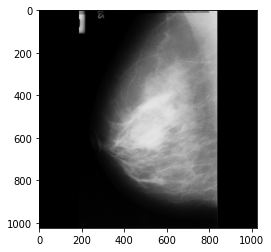

In [ ]:
# check one random image as example
path = Path('/content/archive/all-mias')
img_rand = random.choice([x for x in os.listdir(path) 
                        if os.path.isfile(os.path.join(path, x))])

print("Image: ", img_rand)
plt.imshow(cv2.imread('/content/archive/all-mias/{:}'.format(img_rand)))

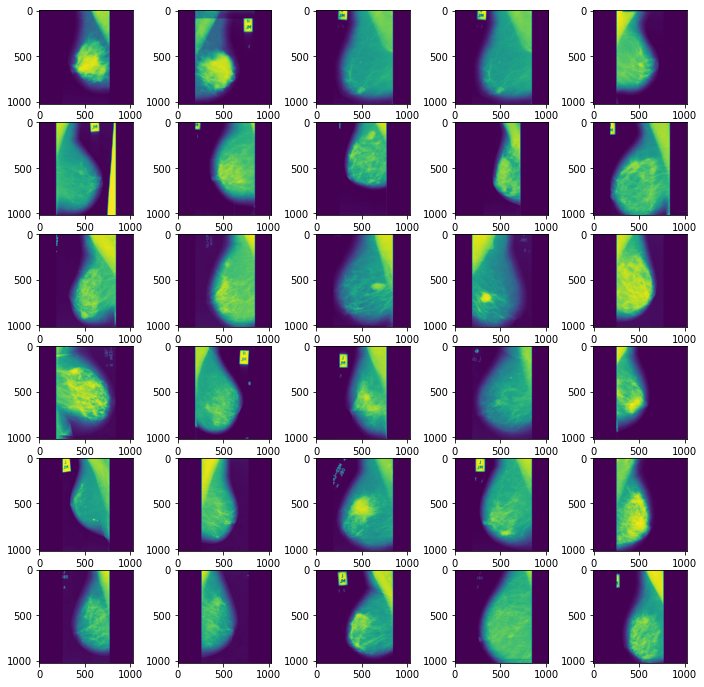

In [ ]:
# show sample of images
  # load images

def load_img(path_to_img):
  max_dim = 1024
  img = PIL.Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), PIL.Image.ANTIALIAS)
   
  img = kp_image.img_to_array(img)
  
  img = np.expand_dims(img, axis=0)
  return img



# show images
def imshow(img, title=None):
  out = np.squeeze(img, axis=0)

  out = out.astype('uint8') # normalize for visualization
  plt.imshow(out[:,:,0])
  if title is not None:
    plt.title(title)
  



# plot images
plt.figure(figsize=(12,12)) 

for i in range(0,30):
    plt.subplot(6,5,i+1)
    content = load_img(image_path[i]).astype('uint8')
    imshow(content)

plt.show()

## 3.1. Horizontal flip

In [ ]:
# function to generate a horizontal flip to the images
def horizontal_flip (info_file, display = False):

  ''' 
  
  Function to apply a horizontal flip to the images

  Params:
    0: reference number
    1: features
    2: size
    3: class
    4: x_coordinate of the abnormality
    5: y_coordiante of the abnormality
    6: radius in pixels
    7: path of the image
    8: xmin coordinate bounding box
    9: ymin coordinate bounding box
    10: xmax coordinate bounding box
    11: ymax coordinate bounding box
  
  '''

  x_y = []
  x_min_max = []
  y_min_max = []

  for name, path, size_x, size_y, xcoord, ycoord, xmin, xmax, ymin, ymax in zip(info_file.iloc[:, 0], info_file.iloc[:, 7], 
                                                                                info_file.iloc[:, 2], info_file.iloc[:, 2],
                                                                                info_file.iloc[:, 4], info_file.iloc[:, 5],
                                                                                info_file.iloc[:, 8], info_file.iloc[:, 9],
                                                                                info_file.iloc[:, 10], info_file.iloc[:, 11]):
  
    hflip_ = cv2.imread(str(path)) # read image
    hflip = cv2.flip(hflip_, 1) # horizontal flip
    new_path = Path("/content/archive/all-mias/{:}_hflip{:}".format(name, '.jpeg')) # generate new path
    status = cv2.imwrite(str(new_path), hflip) # save new img
    print("Image written to file-system " , new_path,  " :", status) # check if saved properly

    ### adapt bounding boxes points
    xcoord_ = int(1024) - int(xcoord) # needs to be 1024 dynamic
    xmax_ = int(1024) - int(xmin)
    xmin_ = int(1024) - int(xmax)
    x_y.append(np.array([[xcoord_, ycoord]]))
    x_min_max.append(np.array([[xmin_, xmax_]]))
    y_min_max.append(np.array([[ymin, ymax]]))
  
  return x_y, x_min_max, y_min_max

In [ ]:
# apply to our database train and test
x_y_hf_train, x_min_max_hf_train, y_min_max_hf_train = horizontal_flip(train) #train
x_y_hf_test, x_min_max_hf_test, y_min_max_hf_test = horizontal_flip(test) #test

Image written to file-system  /content/archive/all-mias/mdb058_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb130_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb223_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb240_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb212_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb134_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb005_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb186_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb239_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb165_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb178_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb171_hflip.jpeg  : True
Image written to

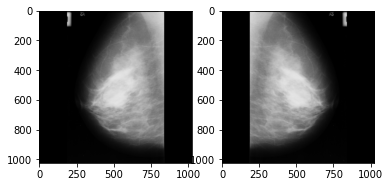

In [ ]:
# check image as example
img = cv2.imread('/content/archive/all-mias/mdb315.pgm')

hflip = cv2.imread('/content/archive/all-mias/mdb315_hflip.jpeg')
plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(hflip)
plt.show()

## 3.2. Removing noise

In [ ]:
# function to remove noise 
def remove_noise (info_file):

  '''
  
  Function removes noise of images contained in a file
  
  Params:
    0: reference number ==> relevant
    1: features
    2: size
    3: class
    4: x_coordinate of the abnormality
    5: y_coordiante of the abnormality
    6: radius in pixels
    7: path of the image ==> relevant

  Gaussian noise is assumed
  
  '''

  for name, path in zip(info_file.iloc[:, 0], info_file.iloc[:, 7]):
    noise_ = cv2.imread(path) # read image
    noise = cv2.fastNlMeansDenoising(noise_,None,10,7,21) # remove noise
    new_path = '/content/archive/all-mias/{:}_noise.jpeg'.format(name) # generate new path
    status = cv2.imwrite(str(new_path), noise) # save new img
    print("Image written to file-system " , new_path,  " :", status) # check if saved properly

In [ ]:
# apply to our databases
remove_noise(train) #train
remove_noise(test) #test

Image written to file-system  /content/archive/all-mias/mdb058_noise.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb130_noise.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb223_noise.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb240_noise.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb212_noise.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb134_noise.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb005_noise.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb186_noise.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb239_noise.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb165_noise.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb178_noise.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb171_noise.jpeg  : True
Image written to

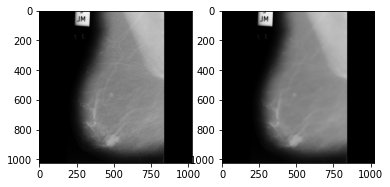

In [ ]:
# check image as example
img = cv2.imread('/content/archive/all-mias/mdb005.pgm')

noise = cv2.imread('/content/archive/all-mias/mdb005_noise.jpeg')
plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(noise)
plt.show()

## 3.3. Rotation images

In [ ]:
# function to rotate images
def rotate_images (info_file, display = False):

  ''' 

  Function to rotate images for the files in the database 

  Params:
    0: reference number
    1: features
    2: size
    3: class
    4: x_coordinate of the abnormality
    5: y_coordiante of the abnormality
    6: radius in pixels
    7: path of the image
    8: xmin
    9: ymin
    10: xmax
    11: ymax
  
  '''

  x_y = []
  x_min_max = []
  y_min_max = []

  for name, path, xcoord, ycoord, xmin, ymin, xmax, ymax in zip(info_file.iloc[:, 0], info_file.iloc[:, 7], 
                                              info_file.iloc[:, 4], info_file.iloc[:, 5],
                                              info_file.iloc[:, 8], info_file.iloc[:, 9],
                                              info_file.iloc[:, 10], info_file.iloc[:, 11]):
    img = cv2.imread(path) # read image
    (h, w) = img.shape[:2] # dimensions image
    (cX, cY) = (w // 2, h // 2) # capture centre image
    rot = cv2.getRotationMatrix2D((cX, cY), 45, 1) # rotate image 45 degrees around the centre
    rotated = cv2.warpAffine(img, rot, (w, h))
    
    # rotate points accordingly
    xy = np.array([[int(xcoord), int(ycoord)]])
    ones = np.ones(shape=(len(xy), 1))
    xy_ones = np.hstack([xy, ones])
    xy_points = rot.dot(xy_ones.T).T
    x_y.append(xy_points)

    # xmin_xmax
    x = np.array([[int(xmin), int(xmax)]])
    ones = np.ones(shape=(len(x), 1))
    x_ones = np.hstack([x, ones])
    x_points = rot.dot(x_ones.T).T
    x_min_max.append(x_points)

    # ymin_ymax
    y = np.array([[int(ymin), int(ymax)]])
    ones = np.ones(shape=(len(y), 1))
    y_ones = np.hstack([y, ones])
    y_points = rot.dot(y_ones.T).T
    y_min_max.append(y_points)


    new_path = '/content/archive/all-mias/{:}_rotate.jpeg'.format(name) # generate new path
    status = cv2.imwrite(str(new_path), rotated) # save new img
    print("Image written to file-system " , new_path,  " :", status) # check if saved properly

  return x_y, x_min_max, y_min_max

In [ ]:
# rotate images
x_y_train, x_min_max_train, y_min_max_train = rotate_images(train) #train
x_y_test, x_min_max_test, y_min_max_test = rotate_images(test) #test

Image written to file-system  /content/archive/all-mias/mdb226_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb163_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb207_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb204_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb010_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb274_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb090_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb241_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb145_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb239_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb097_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb160_rotate.jpeg  : True
Imag

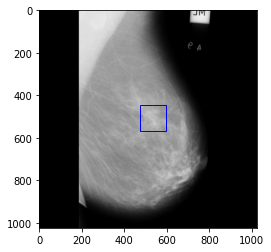

In [ ]:
path = '/content/archive/all-mias/mdb160.pgm'
im = cv2.imread(path)

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

# Create a Rectangle patch
# generate x, y, width and height
xmin = train[train['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,8]
xmax = train[train['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,9]
ymin = train[train['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,10]
ymax = train[train['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,11]
xmin, xmax, ymin, ymax = (xmin.values[0], xmax.values[0], ymin.values[0], ymax.values[0])

width = xmax - xmin
height = ymax - ymin

rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='b', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [ ]:
x_min_max_train[11]

array([[437.753788, 490.07969 ]])

IndexError: ignored

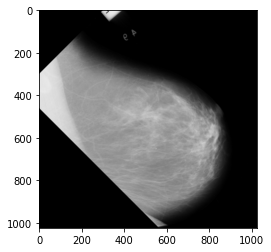

In [ ]:
path = '/content/archive/all-mias/mdb160_rotate.jpeg'
im = cv2.imread(path)

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

# Create a Rectangle patch
# generate x, y, width and height
xmin = x_min_max_train[11][0][0]
xmax = x_min_max_train[11][0][1]
ymin = y_min_max_train[11][0][0]
ymax = y_min_max_train[11][0][1]
#xmin, xmax, ymin, ymax = (xmin.values[0], xmax.values[0], ymin.values[0], ymax.values[0])
xmin = x_min_max_train[11][0][0]
xmax = x_min_max_train[11][0][1]
ymin = y_min_max_train[11][0][0]
ymax = y_min_max_train[11][0][1]
width = xmax - xmin
height = ymax - ymin

rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='b', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

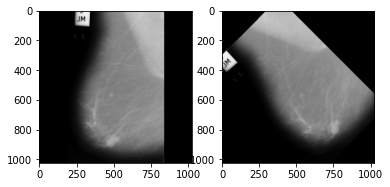

In [ ]:
# check image as example
img = cv2.imread('/content/archive/all-mias/mdb005.pgm')

rotate = cv2.imread('/content/archive/all-mias/mdb005_rotate.jpeg')
plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(rotate)
plt.show()

## 3.4. Mask

In [ ]:
# function to generate a mask to the images
def generate_mask (info_file, display = False):

  ''' 

  Function to generate masks for the images in the database 

  Params:
    0: reference number
    1: features
    2: size
    3: class
    4: x_coordinate of the abnormality
    5: y_coordiante of the abnormality
    6: radius in pixels
    7: path of the image
  
  '''

  for name, size, x_coord, y_coord, radius in zip(info_file.iloc[:, 0], info_file.iloc[:, 2], 
                                                  info_file.iloc[:, 4], info_file.iloc[:, 5], info_file.iloc[:, 6]):
    mask = np.zeros(shape=size, dtype=np.uint8)
    cv2.circle(mask, center = (int(x_coord), int(y_coord)), radius = radius, thickness = -1, color = (255, 255, 255)) # highlight the abnormalities in white colour
    new_path = '/content/archive/all-mias/{:}_mask.pgm'.format(name) # generate new path
    status = cv2.imwrite(str(new_path), mask) # save mask
    print("Image written to file-system " , new_path,  " :", status) # check if saved properly

In [ ]:
# apply to df
generate_mask(train) #train
generate_mask(test) #test

Image written to file-system  /content/archive/all-mias/mdb058_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb130_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb223_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb240_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb212_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb134_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb005_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb186_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb239_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb165_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb178_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb171_mask.pgm  : True
Image written to file-system  /content/a

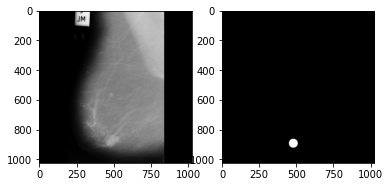

In [ ]:
# check image as example
img = cv2.imread('/content/archive/all-mias/mdb005.pgm')

mask = cv2.imread('/content/archive/all-mias/mdb005_mask.pgm')
plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(mask)
plt.show()

##3.5. Vertical flip

In [ ]:
# function to generate a vertical flip to the images
def vertical_flip (info_file, display = False):

  ''' 
  
  Function to apply a vertical flip to the images

  Params:
    0: reference number
    1: features
    2: size
    3: class
    4: x_coordinate of the abnormality
    5: y_coordiante of the abnormality
    6: radius in pixels
    7: path of the image
    8: xmin coordinate bounding box
    9: ymin coordinate bounding box
    10: xmax coordinate bounding box
    11: ymax coordinate bounding box
  
  '''

  x_y = []
  x_min_max = []
  y_min_max = []

  for name, path, size_x, size_y, xcoord, ycoord, xmin, xmax, ymin, ymax in zip(info_file.iloc[:, 0], info_file.iloc[:, 7], 
                                                                                info_file.iloc[:, 2], info_file.iloc[:, 2],
                                                                                info_file.iloc[:, 4], info_file.iloc[:, 5],
                                                                                info_file.iloc[:, 8], info_file.iloc[:, 9],
                                                                                info_file.iloc[:, 10], info_file.iloc[:, 11]):
  
    vflip_ = cv2.imread(str(path)) # read image
    vflip = cv2.flip(vflip_, 0) # vertical flip
    new_path = Path("/content/archive/all-mias/{:}_vflip{:}".format(name, '.jpeg')) # generate new path
    status = cv2.imwrite(str(new_path), vflip) # save new img
    print("Image written to file-system " , new_path,  " :", status) # check if saved properly

    ### adapt bounding boxes points
    ycoord_ = int(1024) - int(ycoord) # needs to be 1024 dynamic
    ymax_ = int(1024) - int(ymin)
    ymin_ = int(1024) - int(ymax)
    x_y.append(np.array([[xcoord, ycoord_]]))
    x_min_max.append(np.array([[xmin, xmax]]))
    y_min_max.append(np.array([[ymin_, ymax_]]))
  
  return x_y, x_min_max, y_min_max

In [ ]:
# apply to our database train and test
x_y_vf_train, x_min_max_vf_train, y_min_max_vf_train = vertical_flip(train) #train
x_y_vf_test, x_min_max_vf_test, y_min_max_vf_test = vertical_flip(test) #test

Image written to file-system  /content/archive/all-mias/mdb058_vflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb130_vflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb223_vflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb240_vflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb212_vflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb134_vflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb005_vflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb186_vflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb239_vflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb165_vflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb178_vflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb171_vflip.jpeg  : True
Image written to

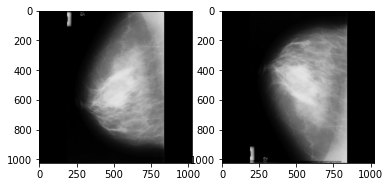

In [ ]:
# check image as example
img = cv2.imread('/content/archive/all-mias/mdb315.pgm')

vflip = cv2.imread('/content/archive/all-mias/mdb315_vflip.jpeg')
plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(vflip)
plt.show()

In [ ]:
train.head()

,name,features,size,cat,x_coord,y_coord,radius,image path,xmin,xmax,ymin,ymax
0,mdb058,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",MISC,318,665,27,/content/archive/all-mias/mdb058.pgm,291,345,638,692
1,mdb130,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",ARCH,220,472,28,/content/archive/all-mias/mdb130.pgm,192,248,444,500
2,mdb223,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CALC,591,495,6,/content/archive/all-mias/mdb223.pgm,585,597,489,501
3,mdb240,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CALC,643,410,23,/content/archive/all-mias/mdb240.pgm,620,666,387,433
4,mdb212,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CALC,687,142,3,/content/archive/all-mias/mdb212.pgm,684,690,139,145


In [ ]:
path = '/content/archive/all-mias/mdb314.pgm'
idx = train[train['image path'].apply(lambda x : x == str(Path(path)))]#.iloc[:,9]
print(idx)
y_min_max_hf_train[1]

Empty DataFrame
Columns: [name, features, size, cat, x_coord, y_coord, radius, image path, xmin, xmax, ymin, ymax]
Index: []


array([[444, 500]])

# 4. Compile images in a df

## 4.1. Train dataset

In [ ]:
## ---------- train dataset ----------

# Map images names with .csv file, which contains the labels
data = []
x_coord = []
y_coord = []
categ = []
xmin = []
ymin = []
xmax = []
ymax = []
size = []
names = []
radius = []
image_path = []
masks = ['_mask']
hflips = ['_hflip']
noises = ['_noise']
vflips = ['_vflip']
rotate = ['_rotate']

with open('/content/archive/train.csv') as file:
  next(file) # skip header
  z = 0
  for l in file:
    for r in rotate:
      i = l.split(",")[1]
      path = '/content/archive/all-mias/{:}{:}.jpeg'.format(i, r)
      img = PIL.Image.open(path)
      data_arr = np.array(img.getdata())
      width, height = np.array(img.size)
      data.append(data_arr)
      size.append((width, height))
      names.append(np.array('{:}{:}'.format(i, r)))
      categ.append(np.array(l.split(",")[5]))
      x_coord.append(x_y_train[z][0][0])
      y_coord.append(x_y_train[z][0][1])
      xmin.append(x_min_max_train[z][0][0])
      xmax.append(x_min_max_train[z][0][1])
      ymin.append(y_min_max_train[z][0][0])
      ymax.append(y_min_max_train[z][0][1])
      radius.append(np.array((l.split(",")[8]).rstrip()))
      image_path.append(path)

    for h in hflips:
      i = l.split(",")[1]
      path = '/content/archive/all-mias/{:}{:}.jpeg'.format(i, h)
      img = PIL.Image.open(path)
      data_arr = np.array(img.getdata())
      width, height = np.array(img.size)
      data.append(data_arr)
      size.append((width, height))
      names.append(np.array('{:}{:}'.format(i, h)))
      categ.append(np.array(l.split(",")[5]))
      x_coord.append(x_y_hf_train[z][0][0])
      y_coord.append(x_y_hf_train[z][0][1])
      xmin.append(x_min_max_hf_train[z][0][0])
      xmax.append(x_min_max_hf_train[z][0][1])
      ymin.append(y_min_max_hf_train[z][0][0])
      ymax.append(y_min_max_hf_train[z][0][1])
      radius.append(np.array((l.split(",")[8]).rstrip()))
      image_path.append(path)

    for v in vflips:
      i = l.split(",")[1]
      path = '/content/archive/all-mias/{:}{:}.jpeg'.format(i, v)
      img = PIL.Image.open(path)
      data_arr = np.array(img.getdata())
      width, height = np.array(img.size)
      data.append(data_arr)
      size.append((width, height))
      names.append(np.array('{:}{:}'.format(i, v)))
      categ.append(np.array(l.split(",")[5]))
      x_coord.append(x_y_vf_train[z][0][0])
      y_coord.append(x_y_vf_train[z][0][1])
      xmin.append(x_min_max_vf_train[z][0][0])
      xmax.append(x_min_max_vf_train[z][0][1])
      ymin.append(y_min_max_vf_train[z][0][0])
      ymax.append(y_min_max_vf_train[z][0][1])   
      radius.append(np.array((l.split(",")[8]).rstrip()))
      image_path.append(path)

    for n in noises:
      i = l.split(",")[1]
      path = '/content/archive/all-mias/{:}{:}.jpeg'.format(i, n)
      img = PIL.Image.open(path)
      data_arr = np.array(img.getdata())
      width, height = np.array(img.size)
      data.append(data_arr)
      size.append((width, height))
      names.append(np.array('{:}{:}'.format(i, n)))
      categ.append(np.array(l.split(",")[5]))
      x_coord.append(np.array(l.split(",")[6]))
      y_coord.append(np.array(l.split(",")[7]))
      xmin.append(np.array(l.split(",")[10]))
      xmax.append(np.array(l.split(",")[11]))
      ymin.append(np.array(l.split(",")[12]))
      ymax.append(int(np.array(l.split(",")[13])))
      radius.append(np.array((l.split(",")[8]).rstrip()))
      image_path.append(path)

    for m in masks:
      i = l.split(",")[1]
      path = '/content/archive/all-mias/{:}{:}.pgm'.format(i, m)
      img = PIL.Image.open(path)
      data_arr = np.array(img.getdata())
      width, height = np.array(img.size)
      data.append(data_arr)
      size.append((width, height))
      names.append(np.array('{:}{:}'.format(i, m)))
      categ.append(np.array(l.split(",")[5]))
      x_coord.append(np.array(l.split(",")[6]))
      y_coord.append(np.array(l.split(",")[7]))
      xmin.append(np.array(l.split(",")[10]))
      xmax.append(np.array(l.split(",")[11]))
      ymin.append(np.array(l.split(",")[12]))
      ymax.append(int(np.array(l.split(",")[13])))
      radius.append(np.array((l.split(",")[8]).rstrip()))
      image_path.append(path)
      
    z +=1

In [ ]:
# merge data into a df
arr = np.array([names, data, size, categ, x_coord, y_coord, xmin, xmax, ymin, ymax, radius, image_path], dtype = object).T.tolist()
train_ = pd.DataFrame(data = arr, columns = ['name', 'features', 'size', 'cat', 'x_coord', 'y_coord', 'xmin', 'xmax', 
                                          'ymin', 'ymax', 'radius', 'image path'])

# check df
train_.head()

,name,features,size,cat,x_coord,y_coord,xmin,xmax,ymin,ymax,radius,image path
0,mdb058_rotate,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",MISC,483.008622,757.366053,444.824856,757.366053,521.192388,757.366053,27,/content/archive/all-mias/mdb058_rotate.jpeg
1,mdb058_hflip,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",MISC,706,665,679,733,638,692.000000,27,/content/archive/all-mias/mdb058_hflip.jpeg
2,mdb058_vflip,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",MISC,318,359,291,345,332,386.000000,27,/content/archive/all-mias/mdb058_vflip.jpeg
3,mdb058_noise,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",MISC,318,665,291,345,638,692.000000,27,/content/archive/all-mias/mdb058_noise.jpeg
4,mdb058_mask,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",MISC,318,665,291,345,638,692.000000,27,/content/archive/all-mias/mdb058_mask.pgm


In [ ]:
# load previous df
train = pd.read_csv('/content/archive/train.csv', sep = ',')

print(train.head())

# drop column 0
del train['Unnamed: 0']

# concatenate two df
train_pp = pd.concat([train, train_])

# check df
print(train_pp.head())

   Unnamed: 0    name               features          size   cat  x_coord  \
0           0  mdb058  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  MISC      318   
1           1  mdb130  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  ARCH      220   
2           2  mdb223  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CALC      591   
3           3  mdb240  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CALC      643   
4           4  mdb212  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CALC      687   

   y_coord  radius                            image path  xmin  xmax  ymin  \
0      665      27  /content/archive/all-mias/mdb058.pgm   291   345   638   
1      472      28  /content/archive/all-mias/mdb130.pgm   192   248   444   
2      495       6  /content/archive/all-mias/mdb223.pgm   585   597   489   
3      410      23  /content/archive/all-mias/mdb240.pgm   620   666   387   
4      142       3  /content/archive/all-mias/mdb212.pgm   684   690   139   

   ymax  
0   692  
1   500  
2   501  
3   433  
4   145  
     nam

In [ ]:
# check for NaN
train_pp.isnull().sum(axis = 0)

name          0
features      0
size          0
cat           0
x_coord       0
y_coord       0
radius        0
image path    0
xmin          0
xmax          0
ymin          0
ymax          0
dtype: int64

In [ ]:
# check example of mdb160
train_pp[train_pp['image path'].str.contains('mdb160')]

,name,features,size,cat,x_coord,y_coord,radius,image path,xmin,xmax,ymin,ymax
60,mdb160,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",ARCH,536,505,61,/content/archive/all-mias/mdb160.pgm,475,597,444,566.00000
300,mdb160_rotate,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",ARCH,524.020815,490.07969,61,/content/archive/all-mias/mdb160_rotate.jpeg,437.753788,490.07969,610.287843,490.07969
301,mdb160_hflip,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",ARCH,488,505,61,/content/archive/all-mias/mdb160_hflip.jpeg,427,549,444,566.00000
302,mdb160_vflip,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",ARCH,536,519,61,/content/archive/all-mias/mdb160_vflip.jpeg,475,597,458,580.00000
303,mdb160_noise,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",ARCH,536,505,61,/content/archive/all-mias/mdb160_noise.jpeg,475,597,444,566.00000
304,mdb160_mask,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",ARCH,536,505,61,/content/archive/all-mias/mdb160_mask.pgm,475,597,444,566.00000


In [ ]:
# apply integer to all numeric values
train_pp['radius'].apply(int) + train_pp['x_coord'].apply(int) + train_pp['y_coord'].apply(int) + train_pp['xmin'].apply(int)
+ train_pp['xmax'].apply(int) + train_pp['ymin'].apply(int) + train_pp['ymax'].apply(int)

0      1675
1      1192
2      1587
3      1486
4       974
       ... 
410    1409
411    1392
412    1718
413    1510
414    1510
Length: 498, dtype: int64

In [ ]:
### CHECKPOINT
# save df into .csv
train_pp.to_csv("/content/archive/images_preprocess_train.csv", sep = ";")

## 4.2. Test dataset

In [ ]:
## ---------- test dataset ----------

# Map images names with .csv file, which contains the labels
data = []
x_coord = []
y_coord = []
categ = []
xmin = []
ymin = []
xmax = []
ymax = []
size = []
names = []
radius = []
image_path = []
masks = ['_mask']
hflips = ['_hflip']
noises = ['_noise']
vflips = ['_vflip']
rotate = ['_rotate']

with open('/content/archive/test.csv') as file:
  next(file) # skip header
  z = 0
  for l in file:
    for r in rotate:
      i = l.split(",")[1]
      path = '/content/archive/all-mias/{:}{:}.jpeg'.format(i, r)
      img = PIL.Image.open(path)
      data_arr = np.array(img.getdata())
      width, height = np.array(img.size)
      data.append(data_arr)
      size.append((width, height))
      names.append(np.array('{:}{:}'.format(i, r)))
      categ.append(np.array(l.split(",")[5]))
      x_coord.append(x_y_test[z][0][0])
      y_coord.append(x_y_test[z][0][1])
      xmin.append(x_min_max_test[z][0][0])
      xmax.append(x_min_max_test[z][0][1])
      ymin.append(y_min_max_test[z][0][0])
      ymax.append(y_min_max_test[z][0][1])
      radius.append(np.array((l.split(",")[8]).rstrip()))
      image_path.append(path)

    for h in hflips:
      i = l.split(",")[1]
      path = '/content/archive/all-mias/{:}{:}.jpeg'.format(i, h)
      img = PIL.Image.open(path)
      data_arr = np.array(img.getdata())
      width, height = np.array(img.size)
      data.append(data_arr)
      size.append((width, height))
      names.append(np.array('{:}{:}'.format(i, h)))
      categ.append(np.array(l.split(",")[5]))
      x_coord.append(x_y_hf_test[z][0][0])
      y_coord.append(x_y_hf_test[z][0][1])
      xmin.append(x_min_max_hf_test[z][0][0])
      xmax.append(x_min_max_hf_test[z][0][1])
      ymin.append(y_min_max_hf_test[z][0][0])
      ymax.append(y_min_max_hf_test[z][0][1])
      radius.append(np.array((l.split(",")[8]).rstrip()))
      image_path.append(path)

    for v in vflips:
      i = l.split(",")[1]
      path = '/content/archive/all-mias/{:}{:}.jpeg'.format(i, v)
      img = PIL.Image.open(path)
      data_arr = np.array(img.getdata())
      width, height = np.array(img.size)
      data.append(data_arr)
      size.append((width, height))
      names.append(np.array('{:}{:}'.format(i, v)))
      categ.append(np.array(l.split(",")[5]))
      x_coord.append(x_y_vf_test[z][0][0])
      y_coord.append(x_y_vf_test[z][0][1])
      xmin.append(x_min_max_vf_test[z][0][0])
      xmax.append(x_min_max_vf_test[z][0][1])
      ymin.append(y_min_max_vf_test[z][0][0])
      ymax.append(y_min_max_vf_test[z][0][1])   
      radius.append(np.array((l.split(",")[8]).rstrip()))
      image_path.append(path)

    for n in noises:
      i = l.split(",")[1]
      path = '/content/archive/all-mias/{:}{:}.jpeg'.format(i, n)
      img = PIL.Image.open(path)
      data_arr = np.array(img.getdata())
      width, height = np.array(img.size)
      data.append(data_arr)
      size.append((width, height))
      names.append(np.array('{:}{:}'.format(i, n)))
      categ.append(np.array(l.split(",")[5]))
      x_coord.append(np.array(l.split(",")[6]))
      y_coord.append(np.array(l.split(",")[7]))
      xmin.append(np.array(l.split(",")[10]))
      xmax.append(np.array(l.split(",")[11]))
      ymin.append(np.array(l.split(",")[12]))
      ymax.append(int(np.array(l.split(",")[13])))
      radius.append(np.array((l.split(",")[8]).rstrip()))
      image_path.append(path)

    for m in masks:
      i = l.split(",")[1]
      path = '/content/archive/all-mias/{:}{:}.pgm'.format(i, m)
      img = PIL.Image.open(path)
      data_arr = np.array(img.getdata())
      width, height = np.array(img.size)
      data.append(data_arr)
      size.append((width, height))
      names.append(np.array('{:}{:}'.format(i, m)))
      categ.append(np.array(l.split(",")[5]))
      x_coord.append(np.array(l.split(",")[6]))
      y_coord.append(np.array(l.split(",")[7]))
      xmin.append(np.array(l.split(",")[10]))
      xmax.append(np.array(l.split(",")[11]))
      ymin.append(np.array(l.split(",")[12]))
      ymax.append(int(np.array(l.split(",")[13])))
      radius.append(np.array((l.split(",")[8]).rstrip()))
      image_path.append(path)
      
    z +=1

In [ ]:
# merge data into a df
arr = np.array([names, data, size, categ, x_coord, y_coord, xmin, xmax, ymin, ymax, radius, image_path], dtype = object).T.tolist()
test_ = pd.DataFrame(data = arr, columns = ['name', 'features', 'size', 'cat', 'x_coord', 'y_coord', 'xmin', 'xmax', 
                                          'ymin', 'ymax', 'radius', 'image path'])

# check df
test_.tail()

,name,features,size,cat,x_coord,y_coord,xmin,xmax,ymin,ymax,radius,image path
165,mdb241_rotate,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",CALC,352.900974,436.339574,299.160859,436.339574,406.64109,436.339574,38,/content/archive/all-mias/mdb241_rotate.jpeg
166,mdb241_hflip,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",CALC,571,346,533,609,308,384.000000,38,/content/archive/all-mias/mdb241_hflip.jpeg
167,mdb241_vflip,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",CALC,453,678,415,491,640,716.000000,38,/content/archive/all-mias/mdb241_vflip.jpeg
168,mdb241_noise,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",CALC,453,346,415,491,308,384.000000,38,/content/archive/all-mias/mdb241_noise.jpeg
169,mdb241_mask,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CALC,453,346,415,491,308,384.000000,38,/content/archive/all-mias/mdb241_mask.pgm


In [ ]:
from IPython.core.display import TextDisplayObject
# load previous df
test = pd.read_csv('/content/archive/test.csv', sep = ',')

print(test.head())

# drop column 0
del test['Unnamed: 0']

# concatenate two df
test_pp = pd.concat([test, test_])

# check df
print(test_pp.head())

   Unnamed: 0    name               features          size   cat  x_coord  \
0          84  mdb075  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  ASYM      468   
1          85  mdb213  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CALC      547   
2          86  mdb012  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CIRC      471   
3          87  mdb111  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  ASYM      505   
4          88  mdb206  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  SPIC      368   

   y_coord  radius                            image path  xmin  xmax  ymin  \
0      307      23  /content/archive/all-mias/mdb075.pgm   445   491   284   
1      504      45  /content/archive/all-mias/mdb213.pgm   502   592   459   
2      566      40  /content/archive/all-mias/mdb012.pgm   431   511   526   
3      449     107  /content/archive/all-mias/mdb111.pgm   398   612   342   
4      824      17  /content/archive/all-mias/mdb206.pgm   351   385   807   

   ymax  
0   330  
1   549  
2   606  
3   556  
4   841  
     nam

In [ ]:
# check for NaN
test_pp.isnull().sum(axis = 0)

name          0
features      0
size          0
cat           0
x_coord       0
y_coord       0
radius        0
image path    0
xmin          0
xmax          0
ymin          0
ymax          0
dtype: int64

In [ ]:
# check example of mdb
test_pp[test_pp['image path'].str.contains('mdb017')]

,name,features,size,cat,x_coord,y_coord,radius,image path,xmin,xmax,ymin,ymax
17,mdb017,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,547,451,48,/content/archive/all-mias/mdb017.pgm,499,595,403,499.000000
85,mdb017_rotate,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",CIRC,493.615224,444.117749,48,/content/archive/all-mias/mdb017_rotate.jpeg,425.732973,444.117749,561.497475,444.117749
86,mdb017_hflip,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",CIRC,477,451,48,/content/archive/all-mias/mdb017_hflip.jpeg,429,525,403,499.000000
87,mdb017_vflip,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",CIRC,547,573,48,/content/archive/all-mias/mdb017_vflip.jpeg,499,595,525,621.000000
88,mdb017_noise,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",CIRC,547,451,48,/content/archive/all-mias/mdb017_noise.jpeg,499,595,403,499.000000
89,mdb017_mask,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,547,451,48,/content/archive/all-mias/mdb017_mask.pgm,499,595,403,499.000000


In [ ]:
# apply integer to all numeric values
test_pp['radius'].apply(int) + test_pp['x_coord'].apply(int) + test_pp['y_coord'].apply(int) + test_pp['xmin'].apply(int)
+ test_pp['xmax'].apply(int) + test_pp['ymin'].apply(int) + test_pp['ymax'].apply(int)

0      1105
1      1600
2      1643
3      1510
4      2033
       ... 
165    1278
166    1301
167    1847
168    1183
169    1183
Length: 204, dtype: int64

In [ ]:
### CHECKPOINT
# save df into .csv
test_pp.to_csv("/content/archive/images_preprocess_test.csv", sep = ";")

## 4.3. Save files into google drive

In [ ]:
from zipfile import ZipFile
import os

In [ ]:
# zip results
file_paths = []

for root, directories, files in os.walk("/content/archive/all-mias"):
  for filename in files:
    filepath = os.path.join(root, filename)
    file_paths.append(filepath)

with ZipFile("/content/archive/all-mias.zip", "w") as zip:
  for file in file_paths:
    zip.write(file)

In [ ]:
!cp "/content/archive/images_preprocess_train.csv" "/content/gdrive/MyDrive/99_Output" # save result in google drive
!cp "/content/archive/images_preprocess_test.csv" "/content/gdrive/MyDrive/99_Output"
!cp "/content/archive/images_info_0.csv" "/content/gdrive/MyDrive/99_Output"
!cp "/content/archive/images_info_1.csv" "/content/gdrive/MyDrive/99_Output"
!cp "/content/archive/train.csv" "/content/gdrive/MyDrive/99_Output"
!cp "/content/archive/test.csv" "/content/gdrive/MyDrive/99_Output"
!cp "/content/archive/all-mias.zip" "/content/gdrive/MyDrive/99_Output" # save images into google drive